## Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
%matplotlib widget

import pandas as pd

from scipy.signal import correlate
from scipy.stats import zscore
import numpy as np
import datetime as dt

from statsmodels.tsa.seasonal import STL

import os
if not os.path.exists("./figures/"):
    os.makedirs("./figures/")

# Read the data from the csv file
df = pd.read_csv('HEL_12-10-21to08-11-23.csv')
print(df.head())
print(df.describe())

                  date   REG1V.HE   NESTE.HE   ORNBV.HE   KNEBV.HE   OLVAS.HE  \
0  2021-10-12 07:00:00  55.950001  41.820000  35.689999  60.220001  53.099998   
1  2021-10-12 08:00:00  55.799999  41.720001  35.630001  60.419998  53.299999   
2  2021-10-12 09:00:00  55.700001  42.060001  35.400002  60.200001  53.200001   
3  2021-10-12 10:00:00  55.450001  42.009998  35.500000  60.119999  52.900002   
4  2021-10-12 11:00:00  56.000000  42.000000  35.680000  60.480000  52.599998   

    HUH1V.HE   DETEC.HE   ORNAV.HE   CGCBV.HE   VAIAS.HE   ALBBV.HE  \
0  38.529999  23.000000  38.049999  43.139999  46.150002  28.700001   
1  38.560001  23.000000  38.049999  43.500000  45.950001  28.799999   
2  38.349998  23.000000  38.049999  43.619999  45.849998  28.600000   
3  38.220001  23.200001  38.049999  43.480000  45.700001  28.500000   
4  38.349998  23.200001  38.000000  43.279999  45.650002  28.700001   

    VALMT.HE   EQV1V.HE   PON1V.HE  
0  36.459999  24.850000  39.150002  
1  36.599998

## Exploratory Data Analysis

In [2]:
df_regular = df.set_index("date")

fig, ax = plt.subplots(figsize=(10, 6))

df_regular.plot(ax=ax)

num_ticks = 5
xticks_idx = range(0, len(df_regular), len(df_regular)//num_ticks)
plt.xticks(xticks_idx, df_regular.index[xticks_idx].values, rotation=45)

plt.title('Raw stock price data')
plt.xlabel('date')
plt.ylabel('price')

fig.savefig("./figures/raw.svg")

num_columns = len(df_regular.columns)

# Calculate how many rows and columns for subplot
num_rows = (num_columns + 1) // 2  # Add 1 to round up for odd numbers
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows))

for i, column in enumerate(df_regular.columns):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]

    
    ax.hist(df_regular[column], bins=30, edgecolor='black')
    ax.set_title(f'{column}')
    ax.set_xlabel('Price')
    ax.set_ylabel('Frequency')

plt.suptitle('Distributions of the Stocks', )

plt.tight_layout()

fig.savefig("./figures/distributions.svg")
plt.close("all")

## Time Auto-Correlation

## Day Regularization

In [3]:
df_regular = df.set_index("date")
df_regular.index = pd.to_datetime(df_regular.index, format="%Y-%m-%d %H:%M:%S")
df_regular.sort_index(inplace=True)

fig = plt.figure()
aux = (df_regular.index[1:] - df_regular.index[:-1]).to_pytimedelta()
aux = [(td.days*24+td.seconds//3600) for td in aux]
plt.plot(df_regular.index[1:], aux)
plt.title("Time-Deltas (Raw Data)")
plt.xlabel(r"$T[k]$")
plt.ylabel(r"$T[k] - T[k-1]$ [hours]")
plt.xticks(fontsize=6)
fig.savefig("./figures/irregular_timedelta.svg")
plt.close(fig)

daily_df_count = df_regular.groupby(df_regular.index.date).count().mean(axis=1)
daily_obs_hist = plt.figure()
ax = daily_df_count.plot(kind="hist",
                    bins=list(np.arange(daily_df_count.min()-0.5,
                                    daily_df_count.max()+1.5)))
ax.set_xlabel("# observations per day")
ax.set_title("Observations per day (Histogram)")
daily_obs_hist.savefig("./figures/daily_obs_hist.svg")

hourly_df_count = df_regular.groupby(df_regular.index.hour).count().mean(axis=1)
hourly_obs_hist = plt.figure()
ax = hourly_df_count.plot(kind="bar")
ax.set_xlabel("Time of the day")
ax.set_ylabel("Frequency")
ax.set_title("Observations per time of day (Histogram)")
hourly_obs_hist.savefig("./figures/hourly_obs_hist.svg")
plt.close("all")

new_index = []
target_days = pd.date_range(start=df_regular.index[0].date(),
                            end=df_regular.index[-1].date(),
                            freq="D")
for day in target_days:
    if day.to_pydatetime().weekday() > 4:
        continue
    new_index.extend(
        pd.date_range(
            start = day + pd.DateOffset(hours=int(hourly_df_count.index[0])),
            end = day + pd.DateOffset(hours=int(hourly_df_count.index[-1])),
            freq="H"
        )
    )
new_index = list(set(new_index).difference(set(df_regular.index)))
df_regular = pd.concat((df_regular,
                        pd.DataFrame(np.nan,
                                     index=new_index,
                                     columns=df_regular.columns)))
df_regular = df_regular.sort_index().ffill().bfill()

hourly_df_count = df_regular.groupby(df_regular.index.hour).count().mean(axis=1)
hourly_obs_hist = plt.figure()
ax = hourly_df_count.plot(kind="bar")
ax.set_xlabel("Time of the day")
ax.set_ylabel("Frequency")
ax.set_title("Observations per time of day (Histogram) - Regularized")
hourly_obs_hist.savefig("./figures/hourly_obs_hist_regular.svg")
plt.close("all")

fig = plt.figure()
aux = (df_regular.index[1:] - df_regular.index[:-1]).to_pytimedelta()
aux = [(td.days*24+td.seconds//3600) for td in aux]
plt.plot(df_regular.index[1:], aux)
plt.title("Time-Deltas (Regularized Data)")
plt.xlabel(r"$T[k]$")
plt.ylabel(r"$T[k] - T[k-1]$ [hours]")
plt.xticks(fontsize=6)
fig.savefig("./figures/regular_timedelta.svg")
plt.close(fig)

## Auto-Correlation

In [4]:
DAY_LENGTH = 10
WEEK_LENGTH = 5
YEAR_LENGTH= 52

def plot_autocorr(df_internal:pd.DataFrame, stop:int, step:int) -> Figure:
    fig = plt.figure(figsize=(10,5))

    for column in df_internal.columns:
        x = zscore(df_internal[column].to_numpy().flatten())
        x_acorr = correlate(x, x)[len(x)-1:] / (np.linalg.norm(x)**2)
        plt.plot(np.arange(start=0, stop=stop, step=step),
                 x_acorr[:stop:step], label=column, ls="-.")

    plt.gca().legend(loc="best")
    return fig
    

fig_hourly = plot_autocorr(df_regular, stop=1+DAY_LENGTH, step=1)
plt.xticks(np.arange(0,1+DAY_LENGTH,1), np.arange(0,1+DAY_LENGTH,1))
plt.xlabel(r"$t$ [hours]")
plt.ylabel(r"$\rho[t]$")
plt.title("Hourly Autocorrelation")
fig_hourly.savefig("./figures/acorr_hourly.svg")

fig_daily= plot_autocorr(df_regular, stop=1+DAY_LENGTH*WEEK_LENGTH, step=1)
plt.xticks(np.arange(0,1+DAY_LENGTH*WEEK_LENGTH,DAY_LENGTH),
           np.arange(0,1+WEEK_LENGTH))
plt.xlabel(r"$t$ [days]")
plt.ylabel(r"$\rho[t]$")
plt.title("Daily Autocorrelation")
fig_daily.savefig("./figures/acorr_daily.svg")

fig_weekly = plot_autocorr(df_regular,
                           stop=1+DAY_LENGTH*WEEK_LENGTH*YEAR_LENGTH,
                           step=1)
plt.xticks(np.arange(0,1+DAY_LENGTH*WEEK_LENGTH*YEAR_LENGTH,
                        DAY_LENGTH*WEEK_LENGTH),
           np.arange(0,1+YEAR_LENGTH), rotation=90)
plt.xlabel(r"$t$ [weeks]")
plt.ylabel(r"$\rho[t]$")
fig_weekly.savefig("./figures/acorr_weekly.svg")
plt.close("all")

## Trend-Seasonality Decomposition

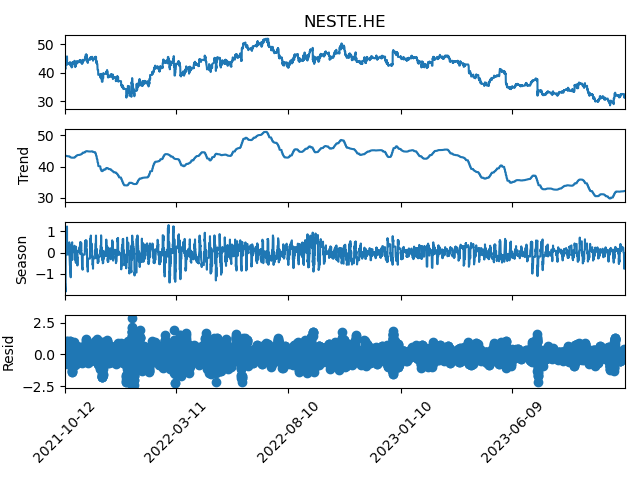

In [30]:
stl = STL(df_regular['NESTE.HE'], period=DAY_LENGTH*WEEK_LENGTH)
res = stl.fit()
fig = res.plot()

xticks_idx = range(0, len(df_regular),
                   len(df_regular)//num_ticks)
plt.xticks(df_regular.index[xticks_idx], rotation=45)
plt.tight_layout()
#fig.savefig("./figures/seasonality.png")
#plt.close()

In [67]:
from statsmodels.tsa.seasonal import MSTL


def mstl_remove_outliers(stock):
    '''
    Removing outliers that lie in 3x standard deviation range for each stock.
    '''
    mstl = MSTL(stock, periods=(DAY_LENGTH*WEEK_LENGTH, DAY_LENGTH*WEEK_LENGTH*12))
    res = mstl.fit()

    cleaned_data = res.trend + (res.seasonal['seasonal_600'] - res.seasonal['seasonal_50'])

    resid = res.resid

    res_mean = resid.mean()
    resid_std = resid.std()

    lower_bound = res_mean - 3 * resid_std
    upper_bound = res_mean + 3 * resid_std

   # Replace the outlier with the mean of neighboring values
    for i in range(len(cleaned_data)):
        if resid[i] < lower_bound or resid[i] > upper_bound:
            
            cleaned_data[i] = np.mean(cleaned_data[max(0, i - 1):i + 2])

    return cleaned_data





df_trend = df_regular.apply(lambda stock: mstl_seasonality_removal(stock))


In [ ]:
res.

'\nlist_stocks = [\'REG1V.HE\',\'NESTE.HE\',\'ORNBV.HE\', \'KNEBV.HE\' ]\n\nfor stock in list_stocks:\n\n    mstl = MSTL(df_regular[stock], periods=(DAY_LENGTH*WEEK_LENGTH, DAY_LENGTH*WEEK_LENGTH*12))\n    res = mstl.fit()\n    \n    fig = res.plot()\n\n    xticks_idx = range(0, len(df_regular),\n                    len(df_regular)//num_ticks)\n    plt.xticks(df_regular.index[xticks_idx], rotation=45)\n    plt.suptitle(f\'Dual Seasonality decomposition, {stock}\')\n    plt.tight_layout()\n    fig.savefig(f"./figures/seasonality_{stock.replace(\'.\',\'\')}.eps", format=\'eps\')\n#plt.close()\n'

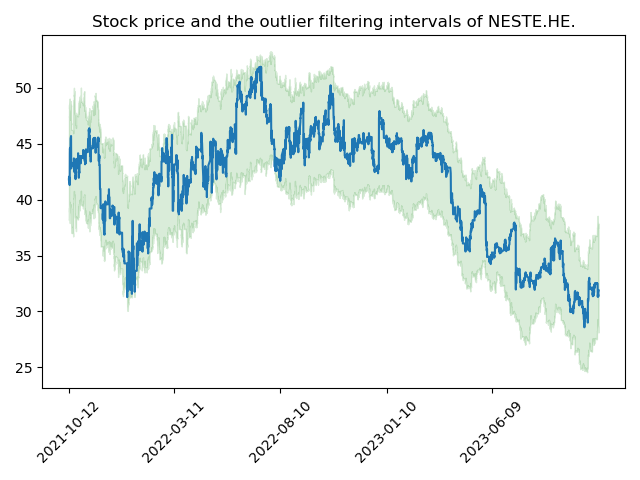

In [73]:
stock = df_regular['NESTE.HE']

mstl = MSTL(stock, periods=(DAY_LENGTH*WEEK_LENGTH, DAY_LENGTH*WEEK_LENGTH*12))
res = mstl.fit()

cleaned_data = res.trend + (res.seasonal['seasonal_600'] - res.seasonal['seasonal_50'])

resid = res.resid

res_mean = resid.mean()
resid_std = resid.std()

lower_bound = res_mean - 3*resid_std
upper_bound = res_mean + 3*resid_std

fig = plt.figure()

plt.plot(stock)
plt.fill_between(cleaned_data.index, cleaned_data - lower_bound, cleaned_data + lower_bound, color = 'g', alpha = 0.15)
plt.title('Stock price and the outlier filtering intervals of NESTE.HE.')
plt.xticks(df_regular.index[xticks_idx], rotation=45)
plt.tight_layout()
fig.savefig(f"./figures/outlier_NESTE.jpg", format='jpg')
'''
list_stocks = ['REG1V.HE','NESTE.HE','ORNBV.HE', 'KNEBV.HE' ]

for stock in list_stocks:

    mstl = MSTL(df_regular[stock], periods=(DAY_LENGTH*WEEK_LENGTH, DAY_LENGTH*WEEK_LENGTH*12))
    res = mstl.fit()
    
    fig = res.plot()

    xticks_idx = range(0, len(df_regular),
                    len(df_regular)//num_ticks)
    plt.xticks(df_regular.index[xticks_idx], rotation=45)
    plt.suptitle(f'Dual Seasonality decomposition, {stock}')
    plt.tight_layout()
    fig.savefig(f"./figures/seasonality_{stock.replace('.','')}.eps", format='eps')
#plt.close()
'''

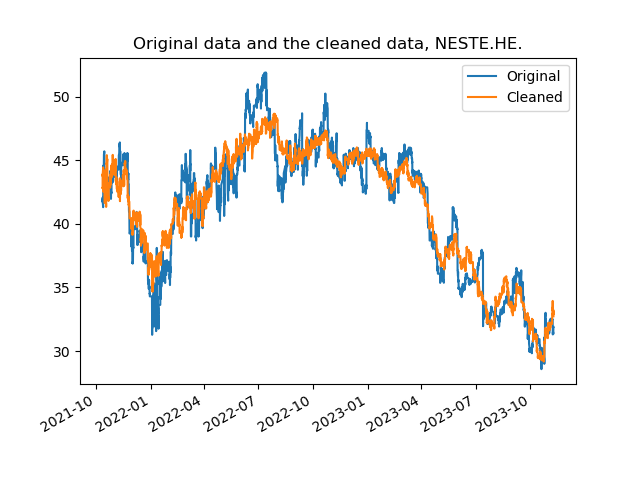

In [76]:

fig = plt.figure()
df_regular['NESTE.HE'].plot()
df_trend['NESTE.HE'].plot()
plt.legend(['Original', 'Cleaned'])
plt.title('Original data and the cleaned data, NESTE.HE.')
fig.savefig(f"./figures/original_cleaned_NESTE.jpg", format='jpg')

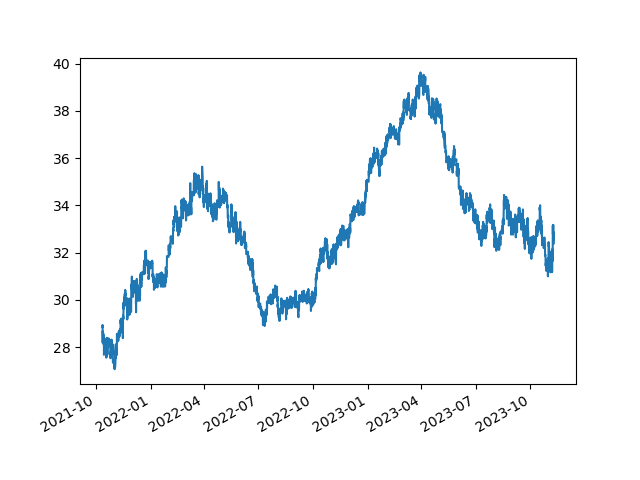

,seasonal_50,seasonal_600
2021-10-12 07:00:00,0.130459,0.530579
2021-10-12 08:00:00,0.071614,0.553955
2021-10-12 09:00:00,0.062346,0.129836
2021-10-12 10:00:00,-0.070043,0.003726
2021-10-12 11:00:00,0.208869,-0.068399
...,...,...
2023-11-08 12:00:00,-0.272936,0.313576
2023-11-08 13:00:00,0.065254,0.139506
2023-11-08 14:00:00,-0.108011,0.194451
2023-11-08 15:00:00,-0.216030,0.294338
